In [4]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

from utils import show_single_frame, show_multiply_frames, get_frames, draw_rois

### Load images

In [5]:
frames, gray_frames = get_frames('./data/camera_calibration/chess/')

In [6]:
show_multiply_frames(frames)

interactive(children=(IntSlider(value=0, description='frame_num', max=21), Output()), _dom_classes=('widget-in…

### Code for calibration

In [16]:
def calibrate_on_chess(frames, gray_frames, chess_shape=(6, 9)):
    
    # find pattern points
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    obj_point = np.zeros((chess_shape[0]*chess_shape[1], 3), np.float32)
    obj_point[:, :2] = np.mgrid[0:chess_shape[0], 0:chess_shape[1]].T.reshape(-1,2)

    obj_points = [] 
    frame_points = [] 

    for gray_frame, frame in tqdm(zip(gray_frames, frames)):

        ret, corners = cv2.findChessboardCorners(gray_frame, chess_shape, None)

        if ret == True:
            corners = cv2.cornerSubPix(gray_frame, corners, (11, 11), (-1, -1), criteria)
            obj_points.append(obj_point)
            frame_points.append(corners)
            
    # calibrate
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, frame_points,
                                                       gray_frames[0].shape[::-1], None, None,
                                                       flags=cv2.CALIB_FIX_K3)
    camera_matrix = np.array(mtx)
    dist_coeff = np.array(dist)
    
    # find new camera matrix
    height, width = frames[0].shape[:2]
    new_camera_matrix, _ = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeff,
                                                        (width, height), 1, (width, height))
    
    return camera_matrix, new_camera_matrix, dist_coeff

def undistort(frame, camera_matrix, new_camera_matrix, dist_coeff):
    return cv2.undistort(frame, camera_matrix, dist_coeff, None, new_camera_matrix)
    
    
            

### Perform calibration

In [17]:
cam, new_cam, dist = calibrate_on_chess(frames, gray_frames)

### Show results

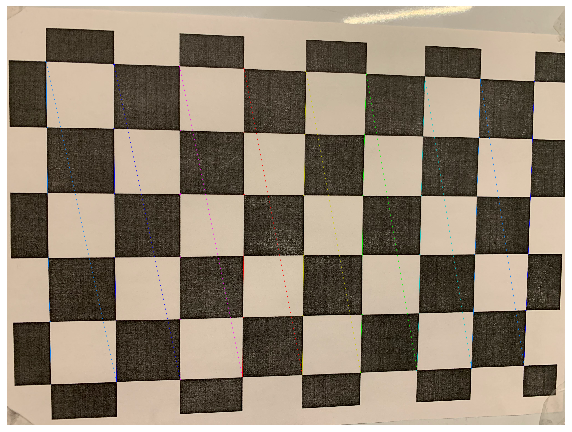

In [21]:
show_single_frame(frames[0], '')

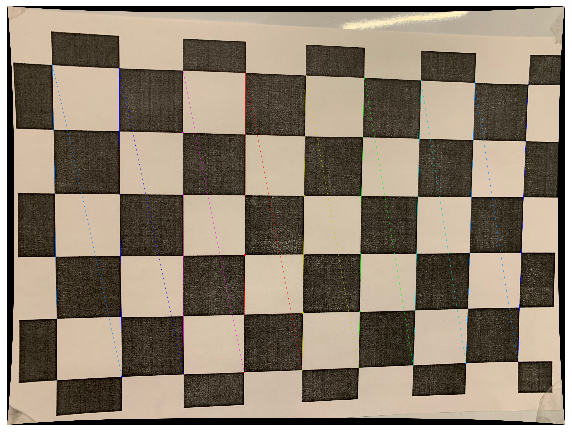

In [22]:
show_single_frame(undistort(frames[0], cam, new_cam, dist), '')